In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.optimize as optimize

import emcee
import corner
import george
from george import kernels

import gaussianprocessregression as gpr

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    #'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

# Simple 1D example

In [3]:
#x = np.array([-6.0, -5.0, -3.0, 0.0, 1.2, 1.5, 1.9, 3.0, 4.0, 5.2, 6, 7])
x = np.linspace(-6.0, 7.0, 50.0)

def func(x):
    return np.sin(x*(1.0+0.05*x)) + 0.5*x + 10

sigma = 0.1
y = func(x) + np.random.normal(0.0, sigma, x.shape)

params = np.array([x]).T
hyperparams = np.array([1.0, 0.1, 1.0])
gp = gpr.GaussianProcess(params, y, gpr.squared_exponential_covariance, hyperparams)
gp.ln_like()

-334.15134668198903

In [4]:
ndim = 1
sigma_f = 5.0
sigma_n = 0.1
l0 = 3.0
hyperparams = np.array([sigma_f, sigma_n, l0])

k = sigma_f**2*kernels.ExpSquaredKernel([l0**2], ndim=ndim) + kernels.WhiteKernel(sigma_n**2, ndim=ndim)

###### Evaluate and compare to Ben's version ########

# value expects arrays x1, x2 each with shape (npoints, ndim) to evaluate the kernel npoints times
x1 = np.array([3.2])
x2 = np.array([3.2])
print k.value(np.array([x1]), np.array([x2]))[0, 0]
print gpr.squared_exponential_covariance(x1, x2, hyperparams)

x1 = np.array([6.0])
x2 = np.array([5.0])
print k.value(np.array([x1]), np.array([x2]))[0, 0]
print gpr.squared_exponential_covariance(x1, x2, hyperparams)

25.01
25.01
23.6489867227
23.6489867227


### Optimize by minimizing the negative log likelihood

In [163]:
# Set up the Gaussian process.
gp = george.GP(k)

# You need to compute the GP once before starting the optimization.
gp.compute(params)

gp.kernel.pars, np.exp(gp.kernel.vector), gp.kernel.vector, gp.kernel, np.exp(gp.kernel[:])**0.5

(array([  2.50000000e+01,   9.00000000e+00,   1.00000000e-02]),
 array([  2.50000000e+01,   9.00000000e+00,   1.00000000e-02]),
 array([ 3.21887582,  2.19722458, -4.60517019]),
 ConstantKernel(25.0, ndim=1) * ExpSquaredKernel(9.0, ndim=1) + WhiteKernel(0.01, ndim=1),
 array([ 5. ,  3. ,  0.1]))

In [6]:
# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(y, quiet=True)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.kernel.vector
results = optimize.minimize(nll, p0, jac=grad_nll)
#results = optimize.minimize(nll, p0)

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x
print(gp.lnlikelihood(y))
print(gp.kernel.vector)
print(gp.kernel.pars**0.5)

-17.3480202365
0.702363142745
[ 4.01019122  1.76584307 -4.43697579]
[ 7.42680394  2.41795353  0.10877346]


(5.9589242746631381, 15.814484779937501)

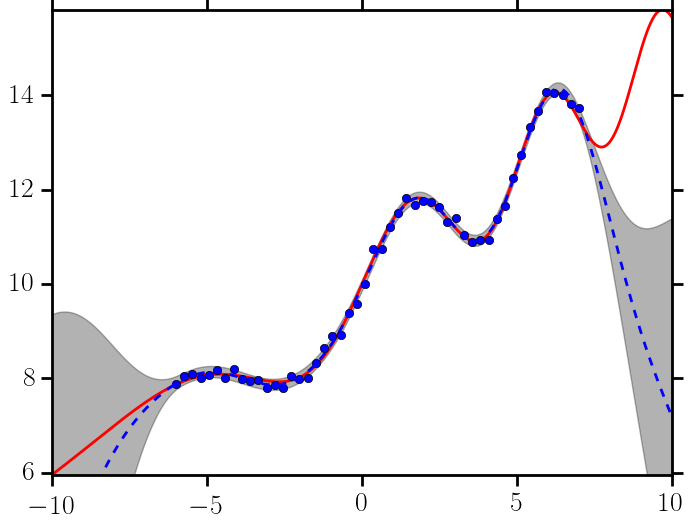

In [7]:
xall = np.linspace(-10, 10, 1000)
yall = func(xall)

xs = np.linspace(-10, 10, 1000)
ys, cov = gp.predict(y, xs)
ys_err = np.sqrt(np.diag(cov))

fig, axes = plt.subplots(figsize=(8, 6))
axes.plot(xall, yall, c='r', lw=2)
axes.plot(x, y, 'bo')
axes.plot(xs, ys, c='b', ls='--', lw=2)
axes.fill_between(xs, ys-ys_err, ys+ys_err, color='k', alpha=0.3)
axes.set_ylim(np.min(yall), np.max(yall))

In [8]:
xgrid = np.arange(0, 10, 0.1)
ygrid = np.arange(0, 10, 0.1)
X, Y = np.meshgrid(xgrid, ygrid)
Z = np.array([[nll(np.array([x1, y1, -4.72966609])) for x1 in xgrid] for y1 in ygrid])

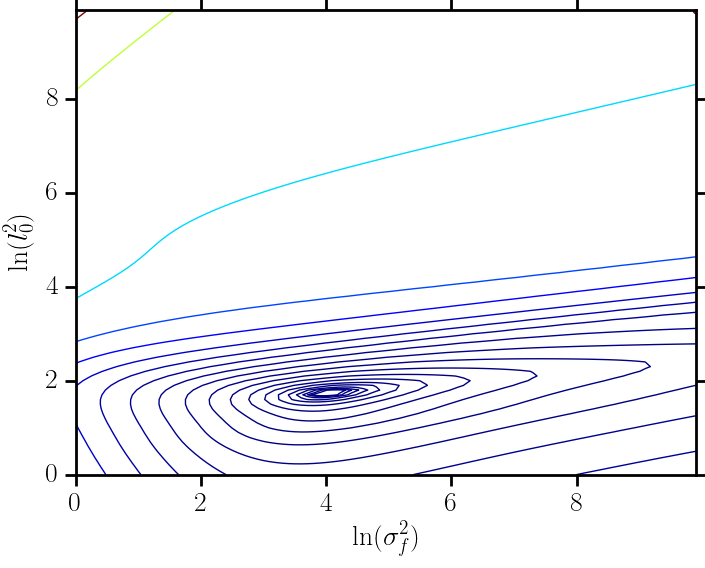

In [9]:
levels = Z.min() + np.logspace(-1, 3.5, 20)

fig, axes = plt.subplots(figsize=(8, 6))
#axes.contour(X, Y, Z)
axes.contour(X, Y, Z, levels)
#axes.clabel(CS, inline=1, fontsize=10)
axes.plot(gp.kernel.vector[0], gp.kernel.vector[1], 'ro', markersize=5)
axes.set_xlabel(r'$\ln(\sigma_f^2)$')
axes.set_ylabel(r'$\ln(l_0^2)$')

### Optimize by maximizing the log likelihood using MCMC (emcee)

In [24]:
ndim = 1
sigma_f = 7.30382846
sigma_n = 0.10506817
l0 = 2.47806044

hyperparams = np.array([sigma_f, sigma_n, l0])

k = sigma_f**2*kernels.ExpSquaredKernel([l0**2], ndim=ndim) + kernels.WhiteKernel(sigma_n**2, ndim=ndim)

In [5]:
# Set up the Gaussian process.
#gp = george.GP(k, solver=george.BasicSolver)
gp = george.GP(k, solver=george.HODLRSolver)

# You need to compute the GP once before starting the optimization.
gp.compute(params)

gp.kernel.pars, np.exp(gp.kernel.vector), gp.kernel.vector, gp.kernel, np.exp(gp.kernel[:])**0.5

(array([  2.50000000e+01,   9.00000000e+00,   1.00000000e-02]),
 array([  2.50000000e+01,   9.00000000e+00,   1.00000000e-02]),
 array([ 3.21887582,  2.19722458, -4.60517019]),
 ConstantKernel(25.0, ndim=1) * ExpSquaredKernel(9.0, ndim=1) + WhiteKernel(0.01, ndim=1),
 array([ 5. ,  3. ,  0.1]))

In [6]:
def lnlike_gp(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)
    return ll


def lnprior_gp(p):
    lnsigmaf2, lnl02, lnsigman2 = p
    if not -10 < lnsigmaf2 < 10:
        return -np.inf
    if not -10 < lnl02 < 10:
        return -np.inf
    if not -10 < lnsigman2 < 10:
        return -np.inf
    return 0.0


def lnprob_gp(p):
    lp = lnprior_gp(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(p)


def fit_gp(initial, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1.0 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp)

    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1.0 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)

    return sampler

In [7]:
initial = np.array([0.0, 0.0, 0.0])
sampler = fit_gp(initial, nwalkers=32)

Running burn-in
Running second burn-in
Running production


In [8]:
imax = sampler.lnprobability.argmax()
pmax = sampler.flatchain[imax]
print pmax
print np.exp(pmax)**0.5

[ 4.04837556  1.87008699 -4.41057317]
[ 7.56995996  2.54732425  0.11021893]


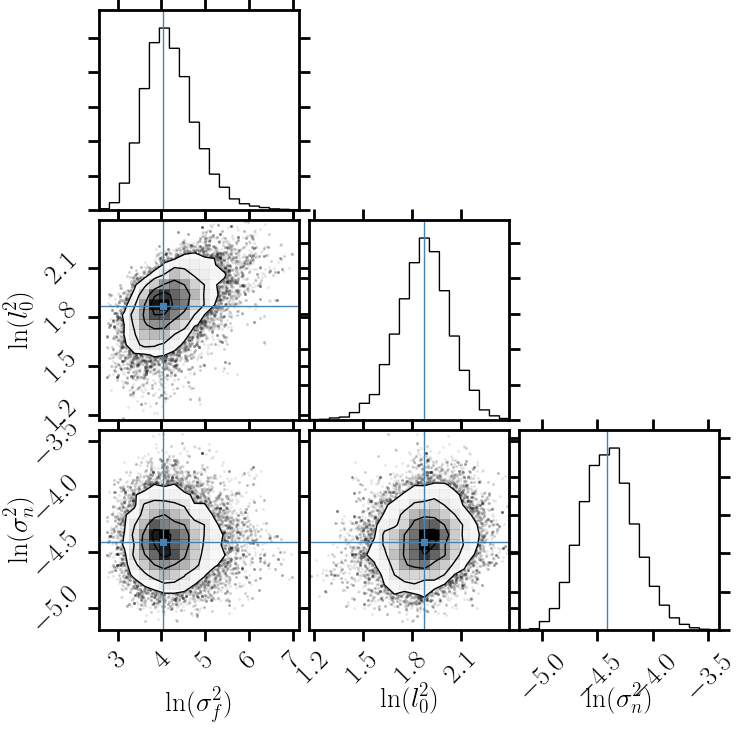

In [9]:
# Make the corner plot.
samples = sampler.flatchain
truths = pmax
labels = [r'$\ln(\sigma_f^2)$', r'$\ln(l_0^2)$', r'$\ln(\sigma_n^2)$']
fig = corner.corner(samples, truths=truths, labels=labels)

In [27]:
gp.predict(y, 5.0, mean_only=False), x, y

((array([ 12.43163441]), array([[ 0.01240347]])),
 array([-6.        , -5.73469388, -5.46938776, -5.20408163, -4.93877551,
        -4.67346939, -4.40816327, -4.14285714, -3.87755102, -3.6122449 ,
        -3.34693878, -3.08163265, -2.81632653, -2.55102041, -2.28571429,
        -2.02040816, -1.75510204, -1.48979592, -1.2244898 , -0.95918367,
        -0.69387755, -0.42857143, -0.16326531,  0.10204082,  0.36734694,
         0.63265306,  0.89795918,  1.16326531,  1.42857143,  1.69387755,
         1.95918367,  2.2244898 ,  2.48979592,  2.75510204,  3.02040816,
         3.28571429,  3.55102041,  3.81632653,  4.08163265,  4.34693878,
         4.6122449 ,  4.87755102,  5.14285714,  5.40816327,  5.67346939,
         5.93877551,  6.20408163,  6.46938776,  6.73469388,  7.        ]),
 array([  7.86242619,   8.12849906,   7.94730371,   8.02995837,
          8.13361383,   8.10483807,   8.21683769,   8.268569  ,
          8.20833558,   7.9689696 ,   8.17816387,   7.97826803,
          7.86358024,   7.

In [19]:
gp.kernel.vector

array([ 4.01714291,  1.82084027, -4.56424225])

[ 4.01714291  1.82084027 -4.56424225]
True


(5.9589242746631381, 15.814484779937501)

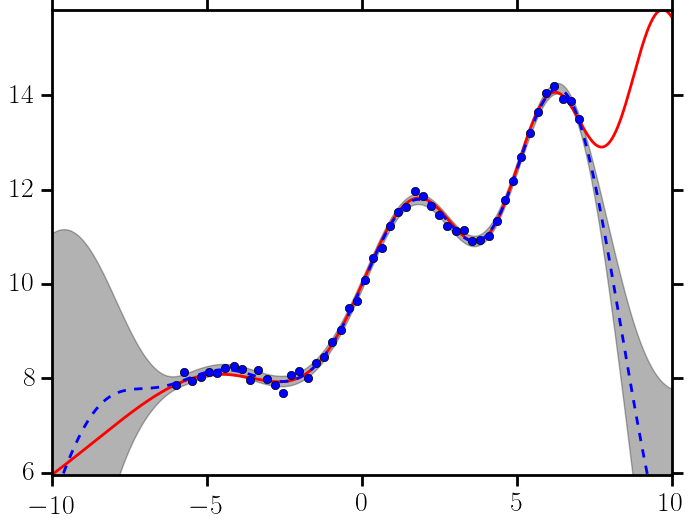

In [26]:
gp.kernel[:] = pmax
gp.compute(params)
print gp.kernel.vector
print gp.computed

xall = np.linspace(-10, 10, 1000)
yall = func(xall)

xs = np.linspace(-10, 10, 1000)
ys, cov = gp.predict(y, xs)
ys_err = np.sqrt(np.diag(cov))

fig, axes = plt.subplots(figsize=(8, 6))
axes.plot(xall, yall, c='r', lw=2)
axes.plot(x, y, 'bo')
axes.plot(xs, ys, c='b', ls='--', lw=2)
axes.fill_between(xs, ys-ys_err, ys+ys_err, color='k', alpha=0.3)
axes.set_ylim(np.min(yall), np.max(yall))

# 2D simple function with Latin hypercube sampling

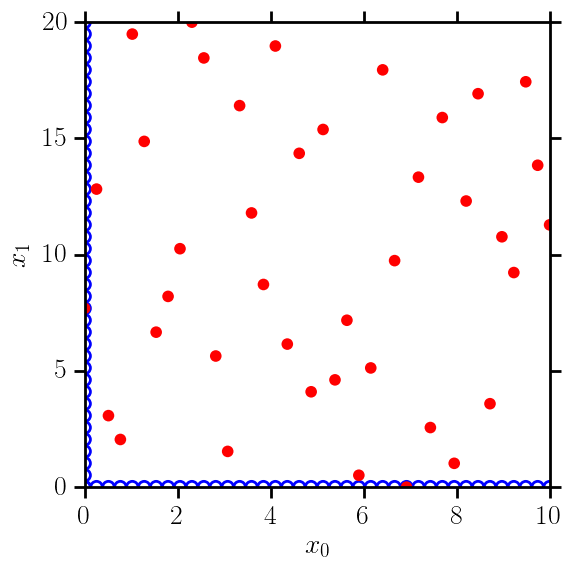

In [82]:
# Make 2d latin hypercube points
Ndata = 40
limits = np.array([[0, 10], [0, 20]])
points = gpr.latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(111)

# for p in points[:, 0]:
#     axes.axvline(p, c='grey', lw=1)

# for p in points[:, 1]:
#     axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

In [83]:
params = points

# Generate data
# def func(x, y):
#     return 0.1*x*np.sin(x) + 0.02*y**2

def func(x, y):
    return (np.sin(x*(1.0+0.05*x)) + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y

data = np.array([func(params[i, 0], params[i, 1]) for i in range(len(params))])

In [84]:
ndim = 2
sigma_f = 3.0
sigma_n = 1.0e-6
l0 = 3
l1 = 10
hyperparams = np.array([sigma_f, sigma_n, l0, l1])

k = sigma_f**2*kernels.ExpSquaredKernel([l0**2, l1**2], ndim=ndim) + kernels.WhiteKernel(sigma_n**2, ndim=ndim)

###### Evaluate and compare to Ben's version ########

# value expects arrays x1, x2 each with shape (npoints, ndim) to evaluate the kernel npoints times
x1 = np.array([4, 1])
x2 = np.array([4, 1])
print k.value(np.array([x1]), np.array([x2]))[0, 0]
print gpr.squared_exponential_covariance(x1, x2, hyperparams)

x1 = np.array([3, 6])
x2 = np.array([4, 1])
print k.value(np.array([x1]), np.array([x2]))[0, 0]
print gpr.squared_exponential_covariance(x1, x2, hyperparams)

9.0
9.0
7.51325671153
7.51325671153


In [85]:
# Set up the Gaussian process.
gp = george.GP(k)

# You need to compute the GP once before starting the optimization.
gp.compute(params)

gp.kernel.pars, np.exp(gp.kernel.vector), gp.kernel.vector, gp.kernel, np.exp(gp.kernel[:])**0.5

(array([  9.00000000e+00,   9.00000000e+00,   1.00000000e+02,
          1.00000000e-12]),
 array([  9.00000000e+00,   9.00000000e+00,   1.00000000e+02,
          1.00000000e-12]),
 array([  2.19722458,   2.19722458,   4.60517019, -27.63102112]),
 ConstantKernel(9.0, ndim=2) * ExpSquaredKernel(9.0, 100.0, ndim=2) + WhiteKernel(1e-12, ndim=2),
 array([  3.00000000e+00,   3.00000000e+00,   1.00000000e+01,
          1.00000000e-06]))

In [86]:
def lnlike_gp(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(data, quiet=True)
    return ll


def lnprior_gp(p):
    lnsigmaf2, lnl02, lnl12, lnsigman2 = p
    if not -3 < lnsigmaf2 < 10:
        return -np.inf
    if not 0 < lnl02 < 10:
        return -np.inf
    if not 0 < lnl12 < 10:
        return -np.inf
    if not -20 < lnsigman2 < -3:
        return -np.inf
    return 0.0


def lnprob_gp(p):
    lp = lnprior_gp(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(p)


def fit_gp(initial, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1.0 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, threads=8)

    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1.0 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 2000)

    return sampler

In [87]:
np.exp(-20)**0.5

4.5399929762484854e-05

In [88]:
np.log(np.array([sigma_f, sigma_n, l0, l1])**2)

array([  2.19722458, -27.63102112,   2.19722458,   4.60517019])

In [89]:
initial = array([  2.19722458, 2.19722458, 4.60517019, -15.0])
sampler = fit_gp(initial, nwalkers=32)

Running burn-in
Running second burn-in
Running production


[ 6.91797105  1.5469371   5.62792978 -9.0813903 ]
[  3.17847154e+01   2.16727052e+00   1.66759054e+01   1.06659895e-02]


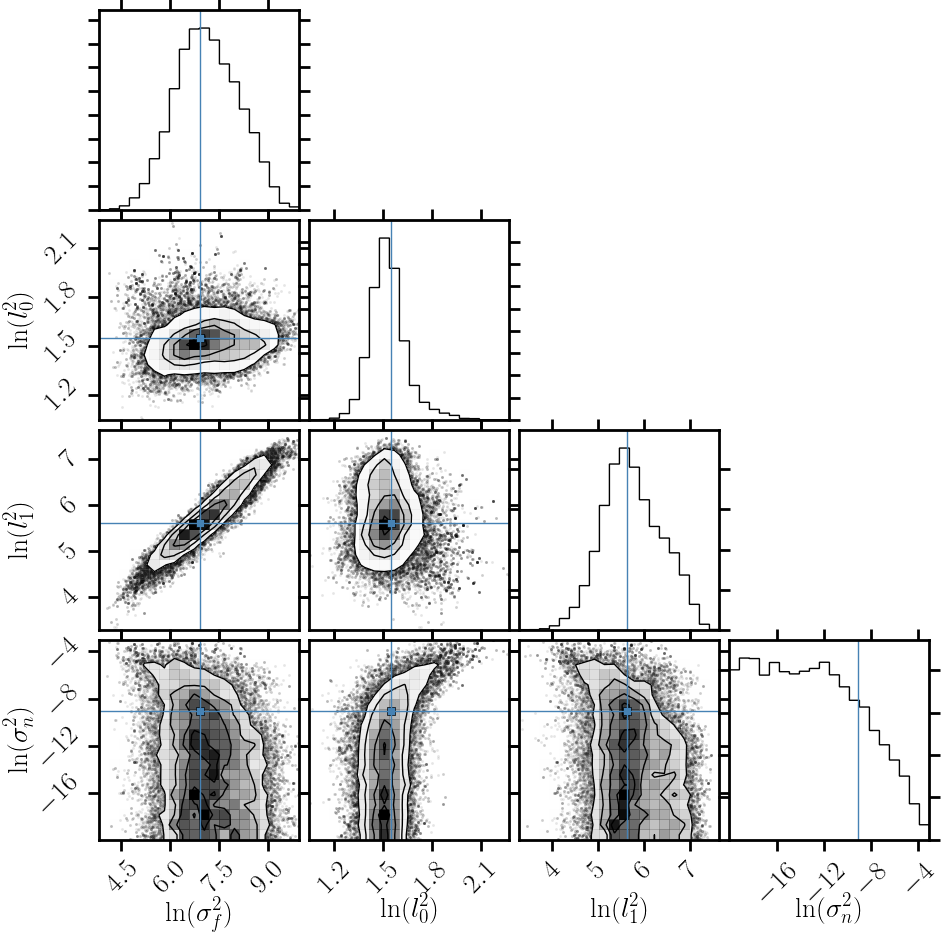

In [90]:
imax = sampler.lnprobability.argmax()
pmax = sampler.flatchain[imax]
print pmax
print np.exp(pmax)**0.5

# Make the corner plot.
samples = sampler.flatchain
truths = pmax
labels = [r'$\ln(\sigma_f^2)$', r'$\ln(l_0^2)$', r'$\ln(l_1^2)$', r'$\ln(\sigma_n^2)$']
fig = corner.corner(samples, truths=truths, labels=labels)

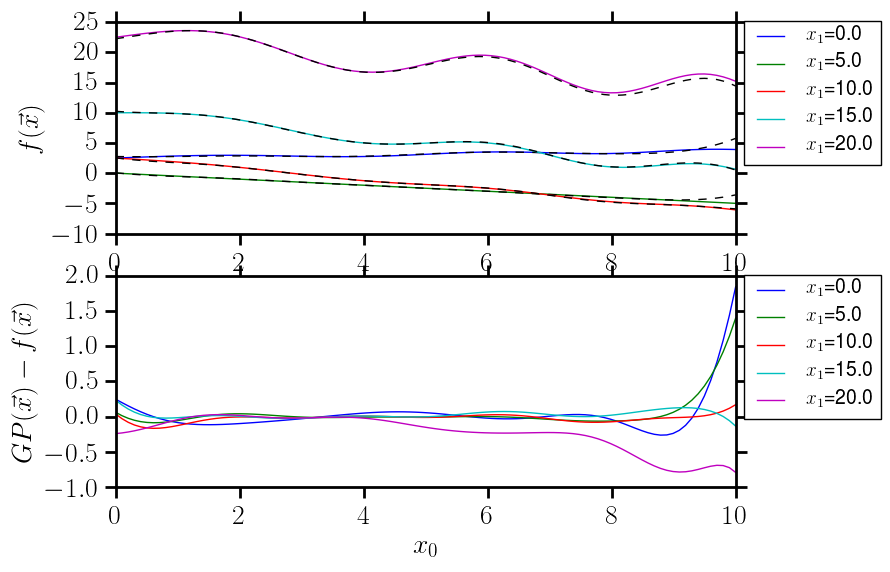

In [92]:
gp.kernel[:] = pmax
#gp.kernel[:] = np.array([6.0, 2.0, 4.5, -16.0])

fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(0, 20, 5):
    xs = np.linspace(0, 10, 100)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    
    interp, cov = gp.predict(data, ps)
    interp_err = np.sqrt(np.diag(cov))
    
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    ax[0].plot(xs, interp, c='k', ls='--')
    
    ax[1].plot(xs, (interp-true), label=r'$x_1$='+str(y))


ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# 3D simple function with Latin hypercube sampling

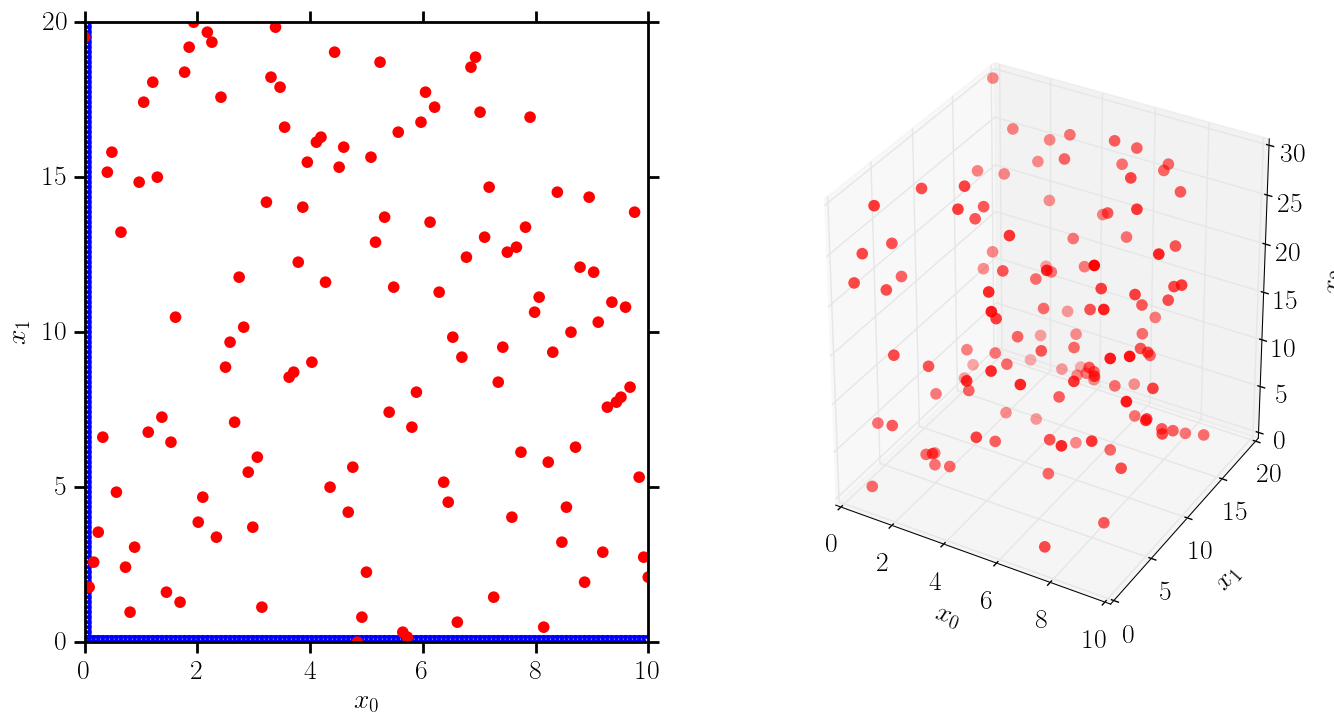

In [107]:
# Make 2d latin hypercube points
Ndata = 125
limits = np.array([[0, 10], [0, 20], [0, 30]])
points = gpr.latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(16, 8))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(121)

# for p in points[:, 0]:
#     axes.axvline(p, c='grey', lw=1)

# for p in points[:, 1]:
#     axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')


# ****** Full 3d data ******
axes = fig.add_subplot(122, projection='3d')

x, y, z = points[:, 0], points[:, 1], points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_zlim(limits[2])
axes.set_xlabel(r'$x_0$', labelpad=10)
axes.set_ylabel(r'$x_1$', labelpad=15)
axes.set_zlabel(r'$x_2$', labelpad=18)

In [149]:
params = points

# Generate data
def func(x, y, z):
    return (np.sin(1.5*x*(1.0+0.05*x)) + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y + 0.02*z**2

data = np.array([func(params[i, 0], params[i, 1], params[i, 2]) for i in range(len(params))])

In [150]:
ndim = 3
sigma_f = 3.0
sigma_n = 1.0e-3
l0 = 3
l1 = 10
l2 = 15
hyperparams = np.array([sigma_f, sigma_n, l0, l1, l2])

k = sigma_f**2*kernels.ExpSquaredKernel([l0**2, l1**2, l2**2], ndim=ndim) + kernels.WhiteKernel(sigma_n**2, ndim=ndim)

###### Evaluate and compare to Ben's version ########

# value expects arrays x1, x2 each with shape (npoints, ndim) to evaluate the kernel npoints times
x1 = np.array([4, 1, 2])
x2 = np.array([4, 1, 2])
print k.value(np.array([x1]), np.array([x2]))[0, 0]
print gpr.squared_exponential_covariance(x1, x2, hyperparams)

x1 = np.array([3, 6, 2])
x2 = np.array([4, 1, 3])
print k.value(np.array([x1]), np.array([x2]))[0, 0]
print gpr.squared_exponential_covariance(x1, x2, hyperparams)

9.000001
9.000001
7.49657912302
7.49657912302


In [151]:
gp1 = george.GP(k, solver=george.BasicSolver)
gp1.compute(params)
print gp1.lnlikelihood(data)

gp2 = george.GP(k, solver=george.HODLRSolver)
gp2.compute(params)
print gp2.lnlikelihood(data)

gp_ben = gpr.GaussianProcess(params, data, gpr.squared_exponential_covariance, hyperparams)
np.log(np.linalg.det(gp_ben.K))

-92617.0997451
-92617.0859316


-533.50683353282705

In [152]:
gp_ben.K, gp1.get_matrix(params)

(array([[ 9.000001  ,  4.00386842,  6.90264649, ...,  2.63859735,
          1.61416505,  1.82911506],
        [ 4.00386842,  9.000001  ,  2.54408044, ...,  4.60595231,
          2.68902936,  3.61099429],
        [ 6.90264649,  2.54408044,  9.000001  , ...,  0.78186115,
          0.3809537 ,  0.64207398],
        ..., 
        [ 2.63859735,  4.60595231,  0.78186115, ...,  9.000001  ,
          8.1881708 ,  6.36848045],
        [ 1.61416505,  2.68902936,  0.3809537 , ...,  8.1881708 ,
          9.000001  ,  6.63617786],
        [ 1.82911506,  3.61099429,  0.64207398, ...,  6.36848045,
          6.63617786,  9.000001  ]]),
 array([[ 9.000001  ,  4.00386842,  6.90264649, ...,  2.63859735,
          1.61416505,  1.82911506],
        [ 4.00386842,  9.000001  ,  2.54408044, ...,  4.60595231,
          2.68902936,  3.61099429],
        [ 6.90264649,  2.54408044,  9.000001  , ...,  0.78186115,
          0.3809537 ,  0.64207398],
        ..., 
        [ 2.63859735,  4.60595231,  0.78186115, ...,

In [153]:
gp1.solver.log_determinant, gp2.solver.log_determinant

(-533.50683353308352, -533.5068246461917)

In [156]:
# Set up the Gaussian process.
#gp = george.GP(k, solver=george.BasicSolver)
gp = george.GP(k, solver=george.HODLRSolver)

# You need to compute the GP once before starting the optimization.
gp.compute(params)

print gp.lnlikelihood(data)
gp.kernel.pars, np.exp(gp.kernel.vector), gp.kernel.vector, gp.kernel, np.exp(gp.kernel[:])**0.5

-92617.0859316


(array([  9.00000000e+00,   9.00000000e+00,   1.00000000e+02,
          2.25000000e+02,   1.00000000e-06]),
 array([  9.00000000e+00,   9.00000000e+00,   1.00000000e+02,
          2.25000000e+02,   1.00000000e-06]),
 array([  2.19722458,   2.19722458,   4.60517019,   5.4161004 , -13.81551056]),
 ConstantKernel(9.0, ndim=3) * ExpSquaredKernel(9.0, 100.0, 225.0, ndim=3) + WhiteKernel(1e-06, ndim=3),
 array([  3.00000000e+00,   3.00000000e+00,   1.00000000e+01,
          1.50000000e+01,   1.00000000e-03]))

In [157]:
def lnlike_gp(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(data, quiet=True)
    return ll


def lnprior_gp(p):
    lnsigmaf2, lnl02, lnl12, lnl22, lnsigman2 = p
    if not 0 < lnsigmaf2 < 10:
        return -np.inf
    if not -2 < lnl02 < 10:
        return -np.inf
    if not -2 < lnl12 < 10:
        return -np.inf
    if not -2 < lnl22 < 10:
        return -np.inf
    if not -20 < lnsigman2 < -10:
        return -np.inf
    return 0.0


def lnprob_gp(p):
    lp = lnprior_gp(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(p)


def fit_gp(initial, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1.0 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, threads=8)

    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1.0 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 2000)

    return sampler

In [158]:
initial = array([  2.19722458, 2.19722458, 4.60517019, 8.0, -15.0])
sampler = fit_gp(initial, nwalkers=32)

Running burn-in
Running second burn-in
Running production


[  5.93276818   3.67161426   8.14887579   9.33865536 -16.98450153]
[  1.94215659e+01   6.27019295e+00   5.88174099e+01   1.06626032e+02
   2.05051218e-04]


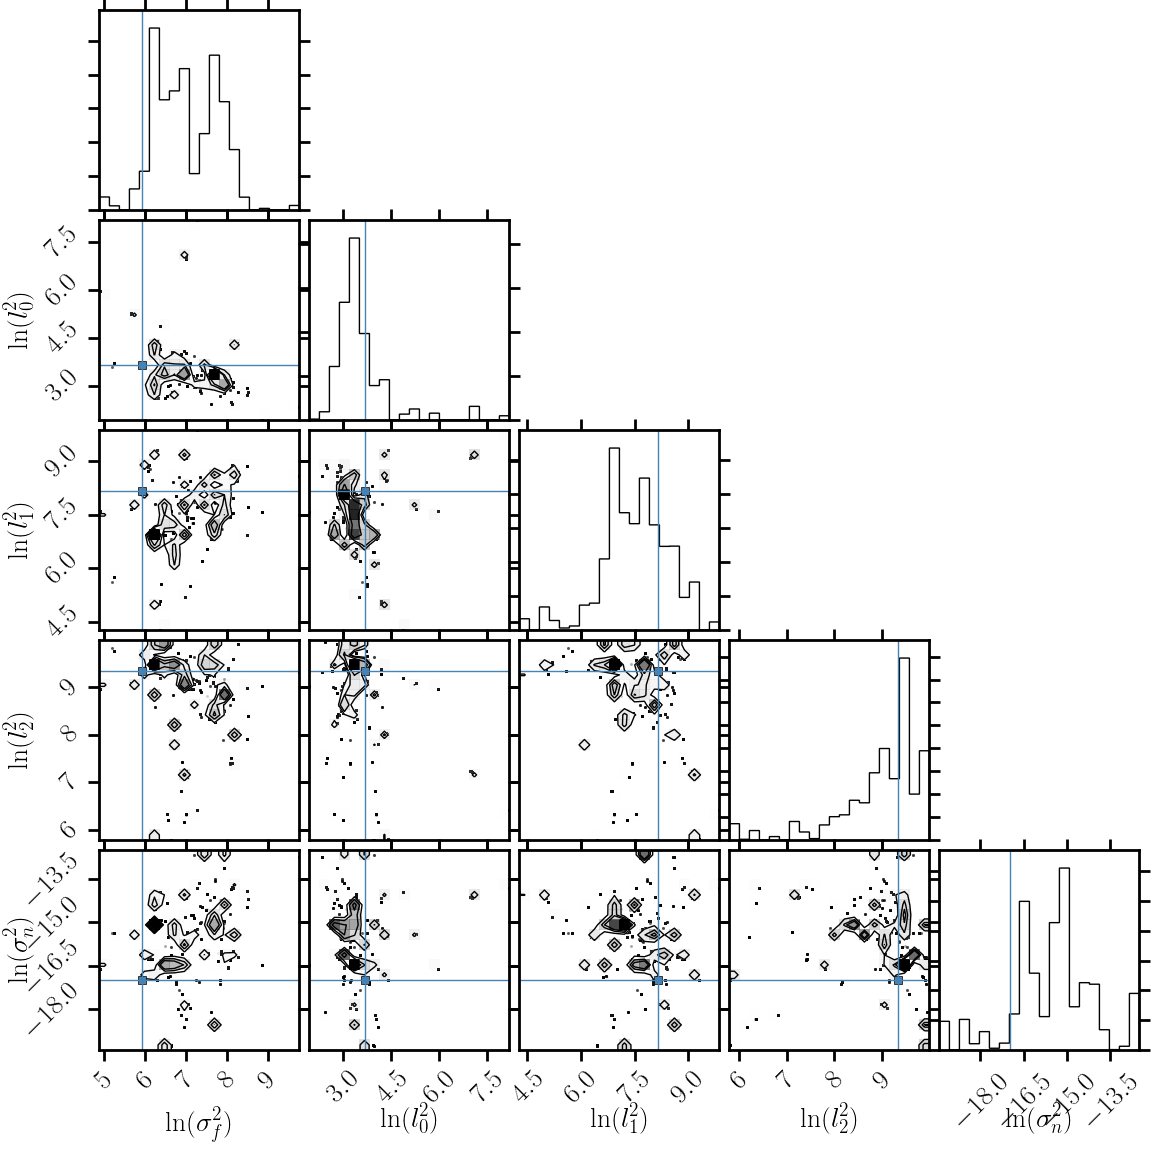

In [159]:
imax = sampler.lnprobability.argmax()
pmax = sampler.flatchain[imax]
print pmax
print np.exp(pmax)**0.5

# Make the corner plot.
samples = sampler.flatchain
truths = pmax
labels = [r'$\ln(\sigma_f^2)$', r'$\ln(l_0^2)$', r'$\ln(l_1^2)$', r'$\ln(l_2^2)$', r'$\ln(\sigma_n^2)$']
fig = corner.corner(samples, truths=truths, labels=labels)

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in sqrt


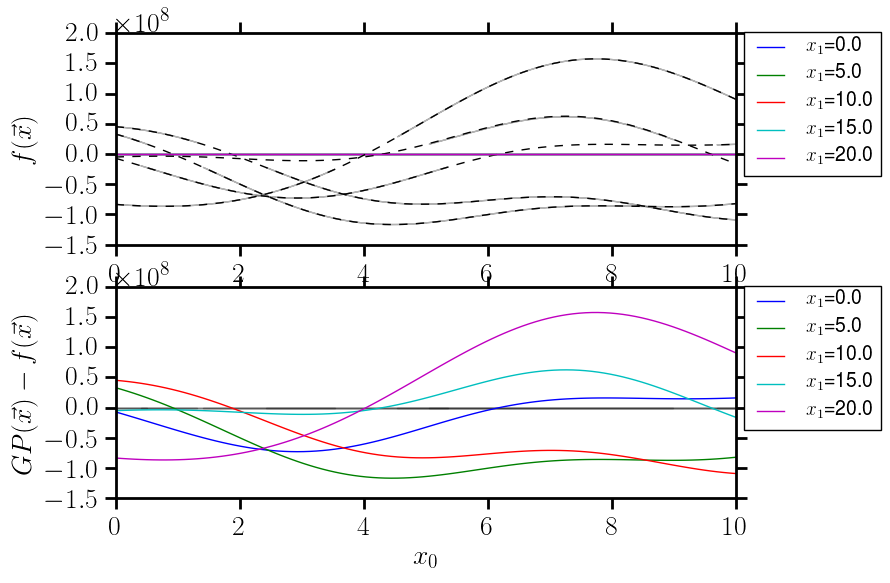

In [160]:
gp.kernel[:] = pmax
#gp.kernel[:] = np.array([6.0, 2.0, 4.5, -16.0])

z = 30.0

fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(0, 20, 5):
    xs = np.linspace(0, 10, 100)
    ps = np.array([[x, y, z] for x in xs])
    
    true = np.array([func(p[0], p[1], p[2]) for p in ps])
    
    interp, cov = gp.predict(data, ps)
    interp_err = np.sqrt(np.diag(cov))
    
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    ax[0].plot(xs, interp, c='k', ls='--')
    ax[0].fill_between(xs, interp-interp_err, interp+interp_err, color='k', alpha=0.3)
    
    ax[1].plot(xs, (interp-true), label=r'$x_1$='+str(y))
    ax[1].fill_between(xs, -interp_err, interp_err, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))